# <strong> Example battery design:</strong> Automating BatPaC V5
   

The following notebook provides an example of the battery design module. The module uses BatPaC version 5 to solve the battery design based on user specific parameters and returns the material content of specific battery design. The notebook contains three examples:

* Example 1: [Single battery design](#example-1---solving-a-single-battery-pack-design)
* Example 2: [Including vehicle parameters](#example-2---including-vehicle-parameters)
* Example 3: [Several battery designs](#example-3---solving-multiple-battery-designs)


<img src='../docs/batpac_python.png' width=800/>


In [2]:
#Import required packages

import pandas as pd
import sys
import matplotlib.pyplot as plt

#Import the battery design module from a local path
sys.path.insert(1, r'C:\Users\Joris\OneDrive - Newcastle University\Python\Projects\Batt_Sust_Model\batt_sust_model')
from battery_design import battery_design as bd

#Local Path to BatPaC version 5. 
# Make sure iterative calculations are enabled (100 iterations is sufficient, see BatPaC manual 3rd edition page 12):
path_batpac = r"C:\Users\Joris\OneDrive - Newcastle University\PhD\Models\battery_sustainability_model\Case study\BatPaC 5.0 10Feb2022.xlsm"

## Example 1 - Solving a single battery pack design
The geometric design of the Volkswagen ID.3 77 kWh version as reported by
[PushEVS.com](https://pushevs.com/2020/05/13/volkswagen-meb-details/) is used as an example (NMC622 is used instead of NMC712, as the latter is not in the public version of BatPaC V5l). All other parameters are BatPaC default parameters.

* usable battery energy: 94%
* Total pack energy: 82 kWh
* Electrode pair: NMC622-G
* Silicon additive anode: 0%
* Cells per module: 24
* Modules per pack: 12
* Modules in parallel: 2 
* Cooling: liquid
* Maximum charging time: 33 minutes (ev-database.org)
* Maximum charge power: 135 kW (ev-database.org)
<br>


In [15]:
#Establish battery system class of specific design:
battery = bd.Battery_system ( vehicle_type='EV', 
                             electrode_pair='NMC622-G (Energy)', 
                             cells_per_module=24, 
                             modules_per_row=6,
                             rows_of_modules=2, 
                             cells_in_parallel=1,
                             silicon_anode= 0.00, 
                             pack_energy=82, 
                             calculate_fast_charge = 'Yes',
                             max_charging_time = 33,  
                             max_charge_power = 135, 
                             available_energy=94)
#Establish parameter dictionary
parameter_dict = battery.parameter_dictionary()

# #Solve battery design in BatPaC returning nested dictionary with material contents and parameter values
# #Make sure BatPaC is not open or running in the background. 
# #BatPaC can run in the foreground if visible=True
result_dict = bd.solve_batpac_battery_system (batpac_path = path_batpac, parameter_dict=parameter_dict, visible=True)

In [17]:
from tabulate import tabulate

headers = [' ', 'BatPaC output', 'VW ID3.']
data = [['Usable capacity (kWh)', result_dict['general_battery_parameters']['pack_usable_energy_kWh'], 77],
        ['Batter weight (kg)', round(result_dict['material_content_pack']['battery pack'],1),493],
        ['Pack energy density Wh/kg', round(82/result_dict['material_content_pack']['battery pack'],4)*1000, 166.3],
        ['Cell weight (kg)', round(result_dict['material_content_pack']['cell']/result_dict['general_battery_parameters']['cells_per_pack'],3),1.073],
        ['Cell capacity (Ah)',round(result_dict['general_battery_parameters']['cell_capacity_ah'], 2),78],
        ['Total cells',result_dict['general_battery_parameters']['cells_per_pack'],288],
        ['Cell energy density (Wh/kg)', result_dict['general_battery_parameters']['specific_energy_cell_Wh/kg'],265]
       ]

print ('Results modelled pack versus VW3 ID3. Data based on PushEV and EPA "Application for Emissions Certification" for ID.4 (same pack):')
print(tabulate(data, headers=headers, numalign="right"))


Results modelled pack versus VW3 ID3. Data based on PushEV and EPA "Application for Emissions Certification" for ID.4 (same pack):
                               BatPaC output    VW ID3.
---------------------------  ---------------  ---------
Usable capacity (kWh)                  77.08         77
Batter weight (kg)                     519.7        493
Pack energy Wh/kg                      157.8      166.3
Cell weight (kg)                       0.917      1.073
Cell capacity (Ah)                     77.62         78
Total cells                              288        288
Cell energy density (Wh/kg)          310.424        265


### Export to Excel
Results can be exported to Excel, resulting in two files: 
* 3_MC_battery_pack_materials: the material content of the battery design
* 3_PAR_battery_design parameters:  includes the design parameters and several technical parameters


In [19]:
bd.export_to_excel(result_dict, 'result_1')

## Example 2 - Including vehicle parameters

## Example 3 - Solving multiple battery designs
In the following example, the battery design module is used to iterate through several design parameters and solve the battery system for several batteries. <br>
Using the function 'solve_batpac_battery_system_multiple', BatPaC is kept open in the background and the model solved for each design parameter (takes about 3 <br>
second to solve BatPaC in Excel with 100 iterations per calculation enabled). <br>

In this example, we will iterature through different cathode chemistries and current collector thickness to identify if the above results can be improved to better match the VW ID.3:

* cathode chemistry: NMC622-G and NMC811-G
* anode current collector thickness: 6 and 8
* cathode current collector thickness: 10 and 12
 <br>



In [ ]:
import itertools as itertools

cathode_chemistry         = ['NMC622-G (Energy)', 'NMC811-G (Energy)']
anode_current_collector   = [6, 8]
cathode_current_collector = [10,12]

dict_design = {}

param_all = list(itertools.product(cathode_chemistry,anode_current_collector,cathode_current_collector))
for param in param_all:
    battery = bd.Battery_system (vehicle_type='EV', electrode_pair=param[0], cells_per_module=24, modules_per_row=6,rows_of_modules=2, 
                                 cells_in_parallel=1,silicon_anode= 0.00, pack_energy=82, available_energy=94, 
                                 negative_foil_thickness=param[1], positive_foil_thickness=param[2])
    parameter_dict = battery.parameter_dictionary()

    #Save each BatPaC output in design dictionary:
    dict_design[param] = parameter_dict
    

Solve BatPaC design model for all battery design options:
Make sure BatPaC is closed

In [ ]:

result_dict_all = bd.solve_batpac_battery_system_multiple (batpac_path = path_batpac, parameter_dict_all=dict_design, visible=True)

  0%|          | 0/8 [00:00<?, ?it/s]


AttributeError: 'NoneType' object has no attribute 'Application'

In [ ]:
data = range(0,5)

In [ ]:

s  = [result_dict_all[x]['general_battery_parameters']['specific_energy_cell_Wh/kg'] for x in result_dict_all.keys()]
d  = [result_dict_all[x]['general_battery_parameters']['energy_density_cell_Wh/L'] for x in result_dict_all.keys()]
    


In [ ]:
s

[328.6117544498728,
 327.3815524393312,
 324.3567105956372,
 323.1542204951903,
 351.909430483573,
 350.64695466113983,
 347.52996729758473,
 346.30102107304566]

In [ ]:
d

[653.315176490761,
 650.7420686292885,
 650.701170647415,
 648.0372177306646,
 685.1025541411351,
 682.4503814488081,
 682.408860825856,
 679.8937159567159]

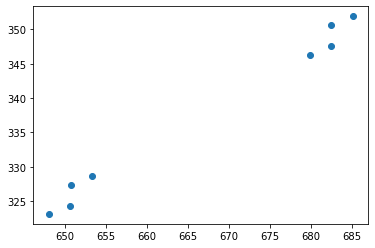

In [ ]:
plt.scatter(d,s)

In [ ]:
headers = ['Example 1',*result_dict_all.keys(), 'VW ID3.']

import matplotlib.pyplot as plt

capacity = []
wt_cell = []
cap_cell= []
total_cell = []
density = []
for x in result_dict_all.keys():
    capacity.append(result_dict_all[x]['general_battery_parameters']['pack_usable_energy_kWh'])
    wt_cell.append(round(result_dict_all[x]['material_content_pack']['cell']/result_dict_all[x]['general_battery_parameters']['cells_per_pack'],3))
    cap_cell.append(round(result_dict_all[x]['general_battery_parameters']['cell_capacity_ah'], 2))
    total_cell.append(result_dict_all[x]['general_battery_parameters']['cells_per_pack'])
    density.append(result_dict_all[x]['general_battery_parameters']['specific_energy_cell_Wh/kg'])

data[0][1:1]=capacity
data[1][1:1]=wt_cell
data[2][1:1]=cap_cell
data[3][1:1]=total_cell
data[4][1:1]=density


headers = ['Baseline',*[str(k) for k in result_dict_all.keys()], 'VW ID3.']

print ('Results modelled pack versus VW3 ID3. pack as reported by PushEVS:\n')
print(tabulate(data, headers=headers, numalign="right"))

TypeError: 'int' object does not support item assignment

<AxesSubplot:>

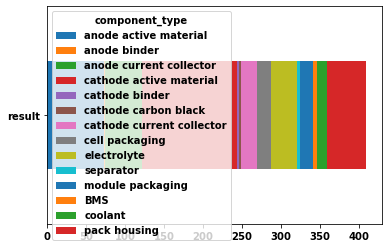

In [ ]:
df.T.plot(kind='barh', stacked=True)

In [ ]:
dic = {}
for x in result_dict_all.keys():
    dic[x] = plot_bar_chart(result_dict_all[x], name=x)
    

ValueError: Invalid file path or buffer object type: <class 'NoneType'>

In [ ]:
from pathlib import Path
import numpy as np

def plot_bar_chart (result_dict, path_comp_type_linkage=None, save=True, name=None):
    """ Plots a donut diagram of the battery bills of material
    Args:
        result_dict (dict): dictionary of battery design module output by name
        comp_type_linkage (str): Path to Excel sheet with battery components by type. Default location is 1_battery_design_module
    """   
    df_types = pd.read_excel(path_comp_type_linkage, index_col='component')

    result = result_dict['material_content_pack']

    df_types[name] = df_types.index.map(result).fillna(0)
    df_types = df_types[(df_types != 0).all(1)]
    df_types = df_types.groupby(['component_type', 'part_off']).sum()
    df_types.sort_values(by='part_off', ascending=True, inplace=True)
    df_types = df_types.reset_index(level=[1])
    df_types.drop('part_off', axis=1, inplace=True)
    labels = list(df_types.index)
    values = list(df_types['result'])

    return df_types


In [ ]:
else:
        df_types = pd.read_excel(path_comp_type_linkage, index_col='component')

    result = result_dict['material_content_pack']

    df_types['result'] = df_types.index.map(result).fillna(0)
    df_types = df_types[(df_types != 0).all(1)]
    df_types = df_types.groupby(['component_type', 'part_off']).sum()
    df_types.sort_values(by='part_off', ascending=True, inplace=True)
    df_types = df_types.reset_index(level=[1])
    labels = list(df_types.index)
    values = list(df_types['result'])
    fig, ax = plt.subplots(figsize=(8, 8))
    centre_circle = plt.Circle((0, 0), 0.70, fc='white')
    fig = plt.gcf()
    fig.gca().add_artist(centre_circle)

    label_kg = []
    for x in range(len(labels)):
        label_kg.append(f'{labels[x]} {round(values[x])}kg')

    cmap = plt.get_cmap("tab20c")
    inner_colors = cmap([0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 13, 16, 17, 18, 19])

    def autopct_format(values):
        def my_format(pct):
            total = sum(values)
            val = int(round(pct * total / 100.0, 1))
            return '{v:d}'.format(v=val)

        return my_format

    wedges, texts = ax.pie(values, wedgeprops=dict(width=0.5), startangle=180, colors=inner_colors)

    bbox_props = dict(boxstyle="square,pad=0.2", fc="w", ec="k", lw=0.72)
    kw = dict(arrowprops=dict(arrowstyle="-"),
              # bbox=bbox_props,
              zorder=0, va="center")

    for i, p in enumerate(wedges):
        ang = (p.theta2 - p.theta1) / 2. + p.theta1
        y = np.sin(np.deg2rad(ang))
        x = np.cos(np.deg2rad(ang))
        horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
        connectionstyle = "angle,angleA=0,angleB={}".format(ang)
        kw["arrowprops"].update({"connectionstyle": connectionstyle})
        ax.annotate(label_kg[i], xy=(x, y), xytext=(1.1 * np.sign(x), 1.2 * y),
                    horizontalalignment=horizontalalignment, **kw, fontsize=13)

    capacity = round(result_dict['general_battery_parameters']['pack_energy_kWh'])
    electrode = result_dict['general_battery_parameters']['electrode_pair']
    weight = round(result_dict['material_content_pack']['battery pack'])
    plt.suptitle(f'{electrode} {capacity} kWh, {weight} kg', fontsize=20)

    ax.axis('equal')
    # plt.tight_layout()
    if save is False:
        return plt.show()
    if save is True:
        if name is False:
            plt.savefig(f'material content {electrode} {capacity} kWh.png', bbox_inches = "tight")
        plt.savefig(f'{name}.png', bbox_inches = "tight")
        return plt.show()

NameError: name 'result_dict' is not defined

# 